# Inference (on real data)

In [16]:
from IPython.display import HTML      # For animation.
from matplotlib import animation      # For animation.
from matplotlib import pyplot as plt  # For plotting.
import numpy as np                    # For solving ODE.
from scipy.integrate import odeint    # For solving ODE.
import cma                            # For optimization.

## Reading data 

In [17]:
# Read data from the file.
data = np.loadtxt('06_data.txt')

# Extract time points (first column).
data_t = data[:, 0]

# Extract prey and predator (third and second column, respectively).
data_y = np.concatenate((data[:, 2:3], data[:, 1:2]), axis=1)

# Initial condition.
y0 = data_y[0]

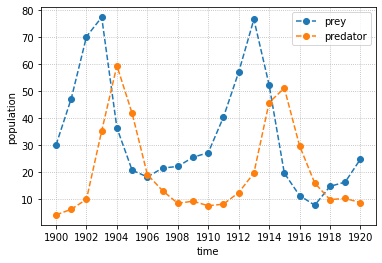

In [10]:
# Time-population plot.
# Show only first set of initial conditions.
plt.plot(data_t, data_y[:, 0], '--o', label='prey')
plt.plot(data_t, data_y[:, 1], '--o', label='predator')
plt.xlabel('time')
plt.ylabel('population')
plt.locator_params(axis='x', nbins=11)
plt.grid(linestyle=':')
plt.legend()
plt.show()

## Optimization (finding optimal parameters) 

In [11]:
def evaluate(params):
    """Given some parameters, calculate how much does
    the Lotka-Vortella result deviate from data."""
    a, b, c, d = params
    F = lambda y, t: [
        y[0] * (a - b * y[1]),   # How population 0 changes.
        y[1] * (-c + d * y[0]),  # How population 1 changes.
    ]

    # Evaluate at the same points the data is available at.
    y = odeint(F, y0, data_t)

    # We define deviation as the sum of squares of differences (Frobenius norm).
    result = np.linalg.norm(y - data_y, 'fro')

    return result

In [12]:
initial_guess = [0.1, 0.05, 0.1, 0.05]  # Initial guess of (a, b, c, d).
lower_bounds = [0.1, 0.001, 0.1, 0.001]
upper_bounds = [0.9, 0.1, 0.9, 0.1]

def constrained_evaluation(params):
    """Wrap `evaluate` function with a penalization that
    keeps the parameters in specific ranges."""
    penalty = 0
    for lb, v, ub in zip(lower_bounds, params, upper_bounds):
        if v < lb:
            penalty += (lb - v) ** 2
        elif v > ub:
            penalty += (v - ub) ** 2
    return 1e6 * penalty + evaluate(params)

es = cma.CMAEvolutionStrategy(initial_guess, 0.5, {'popsize': 64})
cma_result = es.optimize(constrained_evaluation)

print("\nOptimization done! Best parameters:", cma_result.best.get()[0])

(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=545328, Mon Jan 17 12:15:01 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 5.080620019716705e+03 1.0e+00 5.40e-01  4e-01  6e-01 0:00.1
    2    128 5.719740911198134e+02 1.6e+00 5.54e-01  3e-01  6e-01 0:00.2


/usr/local/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


    3    192 1.780037718769029e+02 2.4e+00 4.96e-01  2e-01  4e-01 0:00.3
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1905244781041D+04   r2 =  0.9642388564052D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1905244781041D+04   r2 =  0.9642388564052D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1905244781041D+04   r2 =  0.9642388564052D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.190524478

/usr/local/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=376)
  warnings.warn(msg + ' (' +


  400  25600 2.745389548952118e+01 7.6e+00 1.05e-01  4e-02  9e-02 0:20.5
  500  32000 2.745389548953023e+01 3.0e+02 2.25e+00  9e-02  3e-01 0:25.9
  535  34240 2.745389548953511e+01 3.8e+02 7.70e+00  2e-01  8e-01 0:29.2

Optimization done! Best parameters: [0.54753636 0.02811947 0.84317021 0.02655749]


In [13]:
# Best parameter set is:
cma_result.best.get()[0]

array([0.54753636, 0.02811947, 0.84317021, 0.02655749])

## Visualization of the optimal solution

In [14]:
# Extract parameters as a_, b_, c_ and d_.
a_, b_, c_, d_ = cma_result.best.get()[0]
F_ = lambda y, t: [
    y[0] * (a_ - b_ * y[1]),   # How population 0 changes.
    y[1] * (-c_ + d_ * y[0]),  # How population 1 changes.
]

t = np.linspace(data_t[0], data_t[-1], 100)
y = odeint(F_, y0, t)

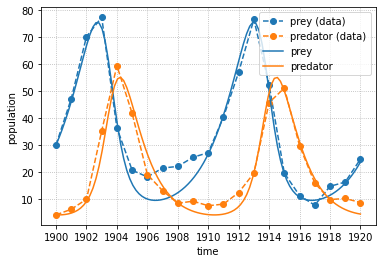

In [15]:
# Time-population plot.
plt.plot(data_t, data_y[:, 0], '--o', color='tab:blue', label='prey (data)')
plt.plot(data_t, data_y[:, 1], '--o', color='tab:orange', label='predator (data)')
plt.plot(t, y[:, 0], color='tab:blue', label='prey')
plt.plot(t, y[:, 1], color='tab:orange', label='predator')
plt.xlabel('time')
plt.ylabel('population')
plt.locator_params(axis='x', nbins=11)
plt.grid(linestyle=':')
plt.legend()
plt.show()